# Distilling a Neural Network into Soft Decision Tree

* Implementation based on [[Frosst & Hinton, 2017](http://arxiv.org/abs/1711.09784)]

## Imports

In [1]:
import numpy as np
import os
import tensorflow as tf

from models import ConvNet, SoftBinaryDecisionTree
from models.utils import brand_new_tfsession, draw_tree
from tensorflow.keras.callbacks import EarlyStopping, Callback

sess = brand_new_tfsession()

## Dataset

In [2]:
# load MNIST data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# hold out last 10000 training samples for validation
x_valid, y_valid = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

(50000, 28, 28) (50000,) (10000, 28, 28) (10000,) (10000, 28, 28) (10000,)


In [3]:
# retrieve image and label shapes from training data
img_rows, img_cols = x_train.shape[1:]
n_classes = np.unique(y_train).shape[0]

print(img_rows, img_cols, n_classes)

28 28 10


In [4]:
# convert labels to 1-hot vectors
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

print(y_train.shape, y_valid.shape, y_test.shape)

(50000, 10) (10000, 10) (10000, 10)


In [5]:
# normalize inputs and cast to float
x_train = (x_train / np.max(x_train)).astype(np.float32)
x_valid = (x_valid / np.max(x_valid)).astype(np.float32)
x_test = (x_test / np.max(x_test)).astype(np.float32)

## Neural Network

In [6]:
nn = ConvNet(img_rows, img_cols, n_classes)
nn.maybe_train(data_train=(x_train, y_train),
               data_valid=(x_valid, y_valid),
               batch_size=16, epochs=12)
nn.evaluate(x_train, y_train)

Loading trained model from assets/nn-model.hdf5.
50000/50000 [==============================] - 3s 64us/step
accuracy: 99.92% | loss: 0.00241056340755782


In [7]:
nn.evaluate(x_valid, y_valid)
nn.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 51us/step
accuracy: 99.27% | loss: 0.03534572134553955
10000/10000 [==============================] - 1s 51us/step
accuracy: 99.29% | loss: 0.027765416074920314


### Extraction of soft labels for distillation

In [8]:
y_train_soft = nn.predict(x_train)
y_train_soft.shape

50000/50000 [==============================] - 2s 45us/step


(50000, 10)

## Binary Soft Decision Tree

Flatten dataset in advance

In [9]:
x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_valid_flat = x_valid.reshape((x_valid.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.imshow(x_test_flat.reshape((x_test_flat.shape[0], img_rows, img_cols))[1])

x_train_flat.shape, x_valid_flat.shape, x_test_flat.shape

((50000, 784), (10000, 784), (10000, 784))

### Hyperparameters
* `tree_depth`: as denoted in the [[paper](https://arxiv.org/pdf/1711.09784.pdf)], depth is in terms of inner nodes (excluding leaves / indexing depth from `0`)
* `penalty_strength`: regularization penalty strength
* `penalty_decay`: regularization penalty decay: paper authors found 0.5 optimal (note that $2^{-d} = 0.5^d$ as we use it)
* `ema_win_size`: scaling factor to the "default size of the window" used to calculate moving averages (growing exponentially with depth) of node and path probabilities
* `inv_temp`: scale logits of inner nodes to "avoid very soft decisions" [[paper](https://arxiv.org/pdf/1711.09784.pdf)]
    * pass `0` to indicate that this should be a learned parameter (single scalar learned to apply to all nodes in the tree)
* `learning_rate`: hopefully no need to explain, but let's be cool and use [Karpathy constant](https://www.urbandictionary.com/define.php?term=Karpathy%20Constant) ([source](https://twitter.com/karpathy/status/801621764144971776)) :D as default in `tree.__init__()`
* `batch_size`: we use a small one, because with increasing depth and thus amount of leaf bigots, larger batch sizes cause their loss terms to be scaled down too much by averaging, which results in poor optimization properties

In [10]:
n_features = img_rows * img_cols
tree_depth = 4
penalty_strength = 1e+1
penalty_decay = 0.25
ema_win_size = 1000
inv_temp = 0.01
learning_rate = 5e-03
batch_size = 4

### Regular training with hard labels

In [11]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

Built tree has 16 leaves out of 31 nodes


In [12]:
epochs = 40

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1)

'''If you wish to train your own model instead of loading one from checkpoint, remove the checkpoint.'''
# os.remove('assets/non-distilled/checkpoint')
# for f in glob.glob('assets/non-distilled/tree-model*'):
#     os.remove(f)

tree.maybe_train(
    sess=sess, data_train=(x_train_flat, y_train), data_valid=(x_valid_flat, y_valid),
    batch_size=batch_size, epochs=epochs, callbacks=[es])

Loading trained model from assets/non-distilled/tree-model.
INFO:tensorflow:Restoring parameters from assets/non-distilled/tree-model


In [13]:
tree.evaluate(x=x_valid_flat, y=y_valid, batch_size=batch_size)
tree.evaluate(x=x_test_flat, y=y_test, batch_size=batch_size)

10000/10000 [==============================] - 18s 2ms/step
accuracy: 81.64% | loss: 16.303977531433105
10000/10000 [==============================] - 16s 2ms/step
accuracy: 80.88% | loss: 16.276673880004882


### Distillation: training with soft labels

In [14]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

Built tree has 16 leaves out of 31 nodes


In [15]:
epochs = 40

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1)

'''If you wish to train your own model instead of loading one from checkpoint, remove the checkpoint.'''
# os.remove('assets/distilled/checkpoint')
# for f in glob.glob('assets/distilled/tree-model*'):
#     os.remove(f)

tree.maybe_train(
    sess=sess, data_train=(x_train_flat, y_train_soft), data_valid=(x_valid_flat, y_valid),
    batch_size=batch_size, epochs=epochs, callbacks=[es], distill=True)

Loading trained model from assets/distilled/tree-model.
INFO:tensorflow:Restoring parameters from assets/distilled/tree-model


In [16]:
tree.evaluate(x=x_valid_flat, y=y_valid, batch_size=batch_size)
tree.evaluate(x=x_test_flat, y=y_test, batch_size=batch_size)

10000/10000 [==============================] - 19s 2ms/step
accuracy: 91.65% | loss: 8.887484398269653
10000/10000 [==============================] - 18s 2ms/step
accuracy: 90.71% | loss: 8.903184248352051


### Visualizing learned parameters

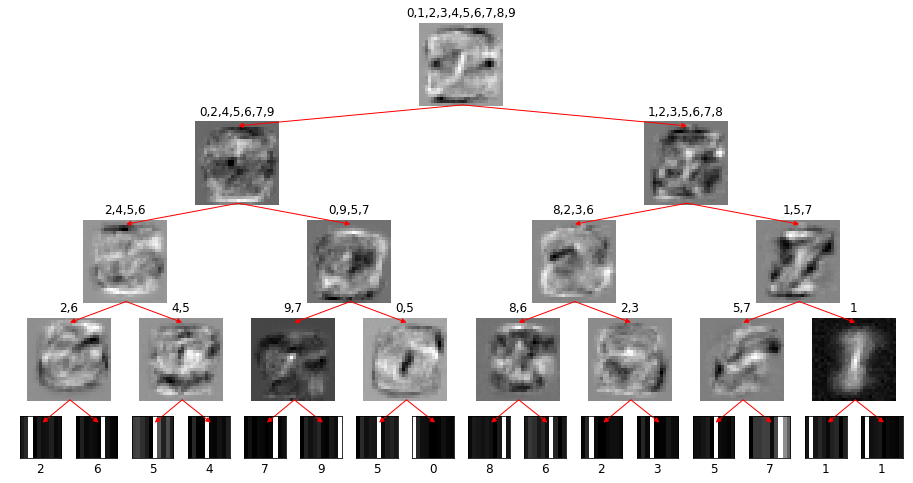

In [17]:
draw_tree(sess, tree, img_rows, img_cols)

#### How to read the visual

Exactly as in the [[paper](https://arxiv.org/pdf/1711.09784.pdf)]:
* Number **below** any **leaf** denotes `argmax()` of learned distribution, thus final static **prediction** of the (bigot, not expert!) leaf.
* Numbers **above** any **inner node** denote the **set of possible predictions** in the sub-tree of the given node.

### Visualizing decision path

In [18]:
digit = 9

# get (reproducibly) pseudo-random example of chosen digit
np.random.seed(0)
sample_index = np.random.choice(np.where(np.argmax(y_test, axis=1)==digit)[0])
input_img = x_test[sample_index]

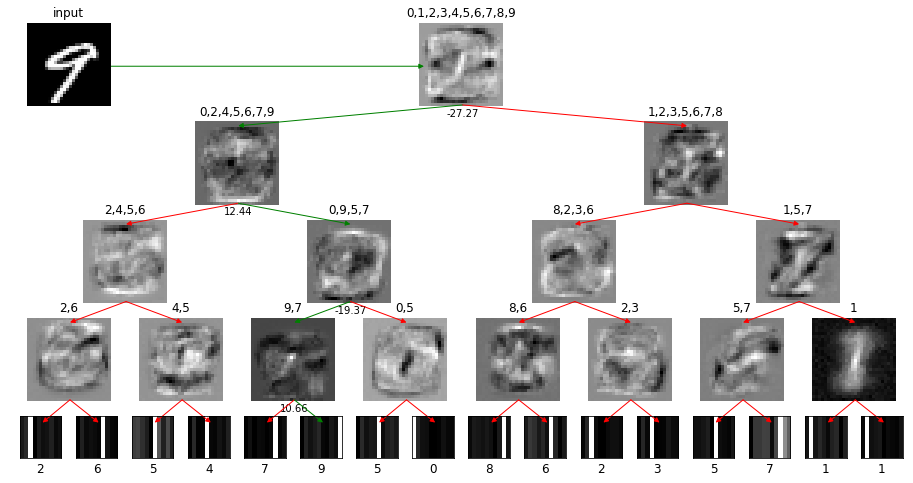

In [19]:
draw_tree(sess, tree, img_rows, img_cols, input_img=input_img)

#### How to read the visual

* The <span style="color:green">**maximum probability path**</span> leading **to final prediction** is now denoted by <span style="color:green"> **green arrows**</span>
* Number **below** any given **inner node** on this <span style="color:green">**path**</span> denotes the **pre-activation logit** $ = (\beta (\mathbf{xw}_i + b_i))$.
    * This is basically just a **biased** ($b_i$) and **scaled** ($\beta$) **correlation** of **input** ($\mathbf{x}$) with the given **mask** ($\mathbf{w}_i$).
    * From the definition of $\sigma$ activation function, the choice of branch breaks around `0`.
    * From the definition of **branching** in the [[paper](https://arxiv.org/pdf/1711.09784.pdf)], **negative** correlations branch **to the left**, while **positive** correlations branch **to the right**.

<img src="assets/img/branching.png" width="35%"/>

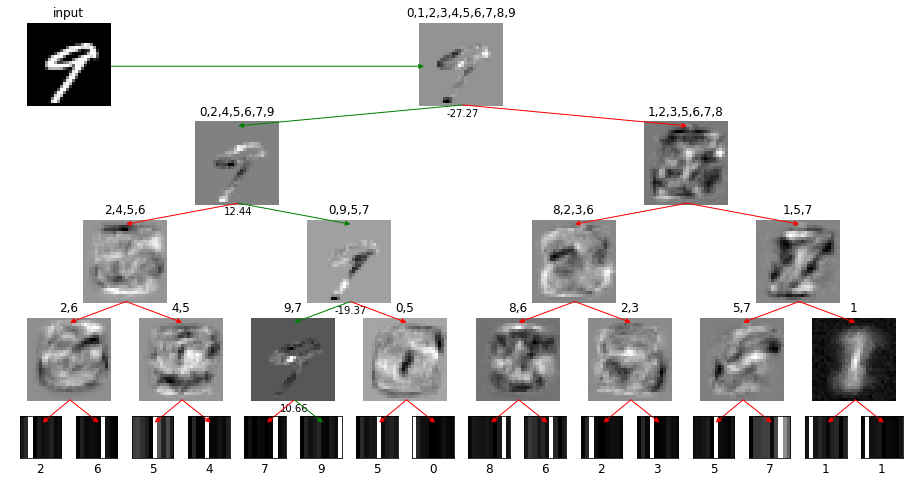

In [20]:
draw_tree(sess, tree, img_rows, img_cols, input_img=input_img, show_correlation=True)

#### How to read the visual

* On the <span style="color:green">**maximum probability path**</span> there are now **correlations** of the **input image** with the **node masks**.
* The **homogeneous area** gives a frame of reference for color of `0`s.
    * It always corresponds to the **black area in the input image**, but due to lack of normalization (yes, I'm the lazy one here), it ends up as different shade of gray in each subplot.
    * All **lighter pixels** from this correspond to **positive correlation coefficients**.
    * All **darker pixels** correspond to **negative correlation coefficients**.

_Note: In the last input-masked kernel on the path to prediction, notice how model recognizes `9`s from `7`s._

To save the inference example as animation, run the cell below.

In [ ]:
if not os.path.isdir('assets/img/infer'):
    os.mkdir('assets/img/infer')

draw_tree(sess, tree, img_rows, img_cols, input_img=input_img,
          savepath='assets/img/infer/0.png')
draw_tree(sess, tree, img_rows, img_cols, input_img=input_img, show_correlation=True,
          savepath='assets/img/infer/1.png')

!convert -delay 100 -loop 0 assets/img/infer/*.png assets/img/infer.gif

### Capturing the progress of learning

In [21]:
if not os.path.isdir('assets/img/epoch'):
    os.mkdir('assets/img/epoch')

if not os.path.isdir('assets/img/sample'):
    os.mkdir('assets/img/sample')

In [22]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

tree.initialize_variables(sess, x_train_flat, batch_size)

Built tree has 16 leaves out of 31 nodes


In [23]:
class ModelImageSaver(Callback):
    def __init__(self, display, limit):
        self.seen = 0
        self.display = display
        self.limit = limit
        
    def on_train_begin(self, logs={}):
        draw_tree(sess, tree, img_rows, img_cols, savepath='assets/img/epoch/{:04}.png'.format(0))
        draw_tree(sess, tree, img_rows, img_cols, savepath='assets/img/sample/{:07}.png'.format(0))
        
    def on_epoch_end(self, epoch, logs={}):
        draw_tree(sess, tree, img_rows, img_cols, savepath='assets/img/epoch/{:04}.png'.format(epoch+1))

    def on_batch_end(self, batch, logs={}):
        self.seen += logs.get('size', 0)
        if self.seen % self.display == 0 and self.seen <= self.limit:
            draw_tree(sess, tree, img_rows, img_cols, savepath='assets/img/sample/{:07}.png'.format(self.seen))

image_saver = ModelImageSaver(1000, 250000)
# save image after each 1000th training example
# save max 250 images (corresponds to first 5 training epochs)

tree.model.fit(x=x_train_flat, y=y_train_soft, validation_data=(x_valid_flat, y_valid),
               batch_size=batch_size, epochs=40, callbacks=[image_saver]);

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 370s 7ms/step - loss: 12.8668 - acc: 0.3092 - val_loss: 8.6232 - val_acc: 0.5996
Epoch 2/40
50000/50000 [==============================] - 363s 7ms/step - loss: 8.7896 - acc: 0.6601 - val_loss: 8.8757 - val_acc: 0.7330
Epoch 3/40
50000/50000 [==============================] - 355s 7ms/step - loss: 8.8130 - acc: 0.7465 - val_loss: 8.7988 - val_acc: 0.7955
Epoch 4/40
50000/50000 [==============================] - 357s 7ms/step - loss: 8.8077 - acc: 0.7870 - val_loss: 8.8376 - val_acc: 0.8191
Epoch 5/40
50000/50000 [==============================] - 358s 7ms/step - loss: 8.8156 - acc: 0.8089 - val_loss: 8.8316 - val_acc: 0.8335
Epoch 6/40
50000/50000 [==============================] - 356s 7ms/step - loss: 8.8071 - acc: 0.8213 - val_loss: 8.8399 - val_acc: 0.8437
Epoch 7/40
50000/50000 [==============================] - 356s 7ms/step - loss: 8.8257 - acc: 0.8302 - val_loss: 8.9278 -

#### Compiling snapshots into animation
**Note**: converting captured series of PNG images into a GIF animation with `makegif.sh` requires `bash` environment with `convert` CLI tool available.

##### Epoch-wise compilation

In [24]:
!./makegif.sh epoch

![epoch.gif](assets/img/epoch.gif)

##### Sample-wise compilation

In [25]:
!./makegif.sh sample

![sample.gif](assets/img/sample.gif)

## Elaborating

![deeper.jpg](assets/img/deeper.jpg)

By now, you should know what's coming...

In [26]:
tree_depth = 5

In [27]:
sess = brand_new_tfsession(sess)

tree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
tree.build_model()

tree.initialize_variables(sess, x_train_flat, batch_size)

Built tree has 32 leaves out of 63 nodes


In [28]:
tree.model.fit(x=x_train_flat, y=y_train_soft, validation_data=(x_valid_flat, y_valid),
               batch_size=batch_size, epochs=3);

# os.mkdir('assets/depth-{}'.format(tree_depth))
# tree.save_variables(sess, 'assets/depth-{}/tree-model'.format(tree_depth))

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 672s 13ms/step - loss: 8.3064 - acc: 0.4097 - val_loss: 8.9103 - val_acc: 0.6509
Epoch 2/3
50000/50000 [==============================] - 663s 13ms/step - loss: 9.1530 - acc: 0.7126 - val_loss: 9.3919 - val_acc: 0.7930
Epoch 3/3
50000/50000 [==============================] - 658s 13ms/step - loss: 9.3712 - acc: 0.8255 - val_loss: 9.4549 - val_acc: 0.8633


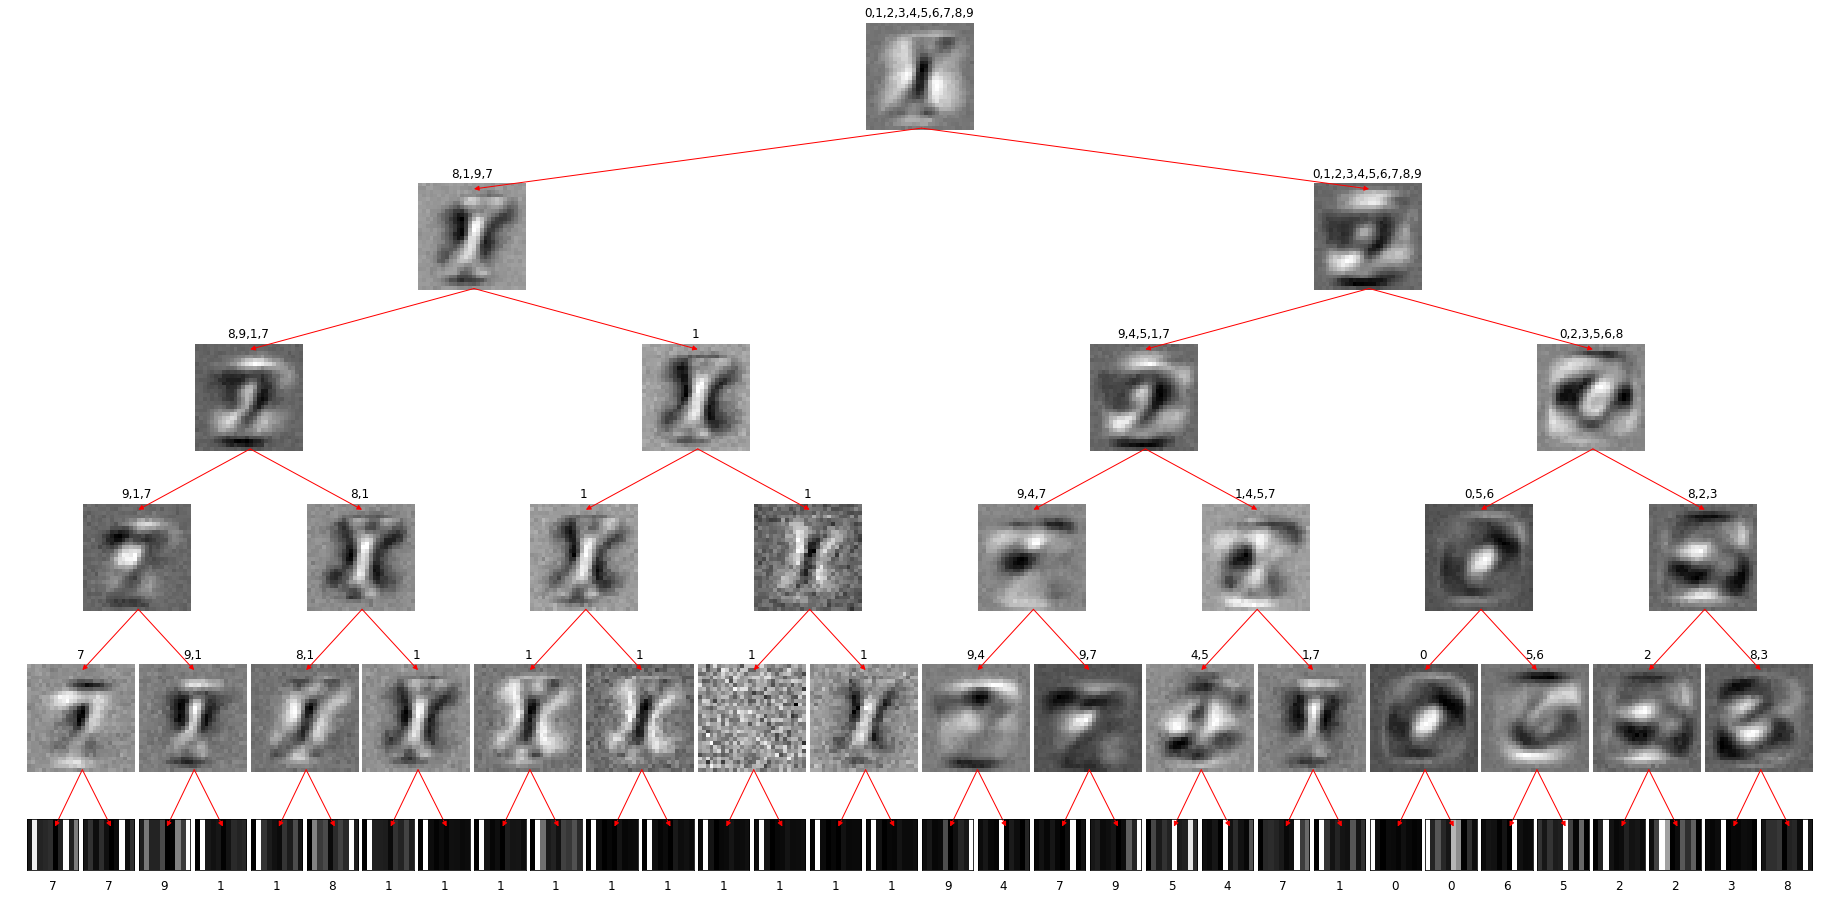

In [29]:
draw_tree(sess, tree, img_rows, img_cols)

Sorry, but deeper than this was not so visually appealing and would take much longer to train to a reasonable performance to even motivate examination.

# Final word

If you're reading this, I believe you are interested in this implementation, so please don't hesitate to **try it yourself** :)

* tune hyperparameters of the tree model
    * try out different depths and penalty parameters (strength, decay)
    * implement dynamic inverse temperature ($\beta$), scheduled as a function of training step / epoch
* try out different dataset, the approach is generic enough!

If you get any interesting results with this implementation, feel free to share them as an [issue](https://github.com/lmartak/distill-nn-tree/issues). Also feel free to improve this repo by submitting a [PR](https://github.com/lmartak/distill-nn-tree/pulls) or just making your own [fork](https://github.com/lmartak/distill-nn-tree/network/members).


If you feel adventurous, you could try:
* improve `draw_tree`'s correlation mode by normalizing the shade of gray around fixed-`0` color shade
* add similar notebook with whole training, distillation & evaluation lifecycle on different dataset (e.g. `cifar-10.ipynb` for [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset)
    * This would probably require colorful masks and some experimenting with their normalization for the purposes of visualization, but could be fun!